Ejercicio 1. Clasificación de dígitos manuscritos

    Framework: TensorFlow y PyTorch

    Dataset: MNIST https://www.tensorflow.org/datasets/catalog/mnist

    Construir una CNN para clasificar dígitos (0–9) a partir de imágenes 28x28.

    Implementación: Redes convolucionales, normalización, precisión.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Cargar datos
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizar imágenes
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

# One-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Construir modelo CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compilar
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Evaluar
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")


c:\Users\Cristhian Ismael\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Cristhian Ismael\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Cristhian Ismael\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9546 - loss: 0.1489 - val_accuracy: 0.9854 - val_loss: 0.0469
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9848 - loss: 0.0494 - val_accuracy: 0.9882 - val_loss: 0.0359
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9892 - loss: 0.0347 - val_accuracy: 0.9875 - val_loss: 0.0398
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9918 - loss: 0.0256 - val_accuracy: 0.9907 - val_loss: 0.0275
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9937 - loss: 0.0194 - val_accuracy: 0.9908 - val_loss: 0.0285
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9908 - loss: 0.0285
Precisión en test: 0.9908


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transforma: normalización a [0,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargar datos
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

# Modelo CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 26x26 -> 13x13
        x = self.pool(torch.relu(self.conv2(x)))  # 11x11 -> 5x5
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
for epoch in range(5):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completada")

# Evaluación
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, pred = torch.max(output, 1)
        correct += (pred == target).sum().item()
        total += target.size(0)

print(f"Precisión en test: {correct / total:.4f}")


Epoch 1 completada
Epoch 2 completada
Epoch 3 completada
Epoch 4 completada
Epoch 5 completada
Precisión en test: 0.9898


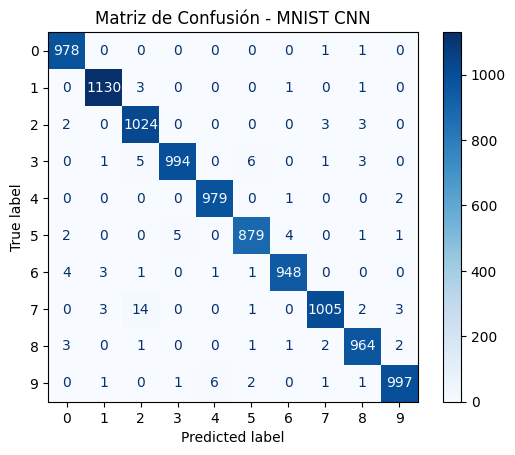

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener todas las predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Crear matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - MNIST CNN")
plt.show()


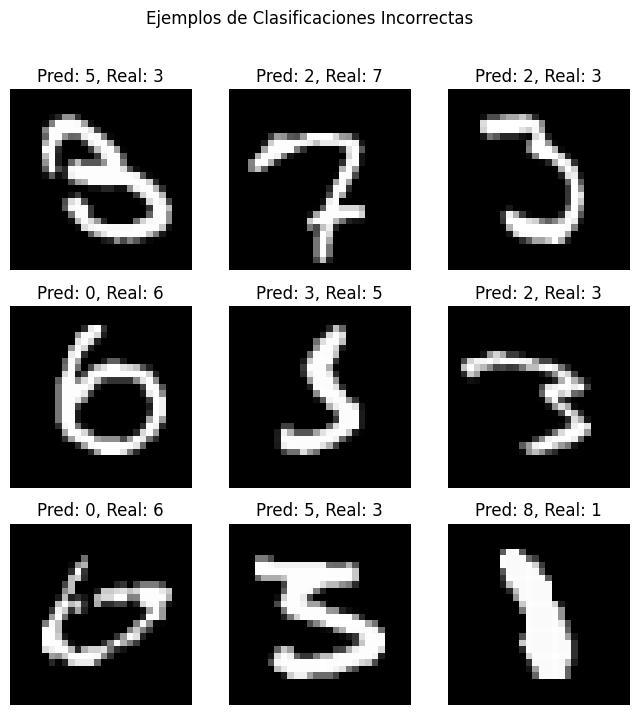

In [4]:
# Visualizar algunas predicciones incorrectas
incorrect_images = []
incorrect_labels = []
incorrect_preds = []

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                incorrect_images.append(data[i])
                incorrect_labels.append(labels[i])
                incorrect_preds.append(predicted[i])
            if len(incorrect_images) >= 9:
                break
        if len(incorrect_images) >= 9:
            break

# Mostrar imágenes
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(incorrect_images[i].squeeze(), cmap='gray')
    ax.set_title(f"Pred: {incorrect_preds[i]}, Real: {incorrect_labels[i]}")
    ax.axis('off')
plt.suptitle("Ejemplos de Clasificaciones Incorrectas")
plt.show()


2. Clasificación de rayos X (neumonía vs sano)

    Framework: Keras + TensorFlow

    Dataset: Chest X-ray Pneumonia (Kaggle) https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

    Detectar neumonía en radiografías con una red convolucional.

    Implementación: Aumento de datos, regularización, evaluación con recall y F1.

In [5]:
import kagglehub

# Descargar y guardar el dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)


100%|██████████| 2.29G/2.29G [00:32<00:00, 75.6MB/s]

Extracting files...


Path to dataset files: C:\Users\Cristhian Ismael\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


Paso 2: Preprocesamiento y Aumento de Datos

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rutas
train_dir = f"{path}/chest_xray/train"
val_dir = f"{path}/chest_xray/val"
test_dir = f"{path}/chest_xray/test"

# Aumento de datos para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Paso 3: Crear modelo CNN con regularización

In [7]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\Cristhian Ismael\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Paso 4: Entrenamiento

In [8]:
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)


c:\Users\Cristhian Ismael\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 452ms/step - accuracy: 0.8336 - loss: 0.4578 - val_accuracy: 0.9375 - val_loss: 0.3737
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 429ms/step - accuracy: 0.9128 - loss: 0.2894 - val_accuracy: 0.6250 - val_loss: 1.1407
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 434ms/step - accuracy: 0.9193 - loss: 0.2641 - val_accuracy: 0.6250 - val_loss: 1.1017


Paso 5: Evaluación con Recall y F1-Score

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predicciones
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Reporte completo
print(classification_report(y_true, y_pred_labels, target_names=['Normal', 'Neumonía']))


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step
              precision    recall  f1-score   support

      Normal       0.97      0.26      0.42       234
    Neumonía       0.69      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.83      0.63      0.62       624
weighted avg       0.80      0.72      0.67       624



Extras: Matriz de confusión

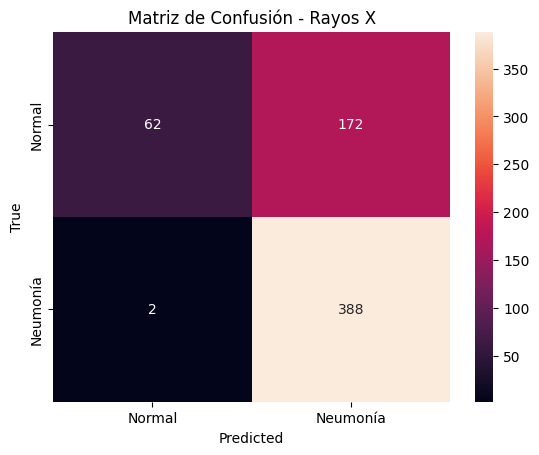

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal', 'Neumonía'], yticklabels=['Normal', 'Neumonía'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Matriz de Confusión - Rayos X")
plt.show()


Ejercicio3_ . Análisis de sentimiento en reseñas de películas

    Framework: TensorFlow o PyTorch

    Dataset: IMDb Sentiment Analysis Dataset https://ai.stanford.edu/~amaas/data/sentiment/

    Objetivo: Clasificar reseñas como positivas o negativas usando LSTM.

    Implementación: Procesamiento de texto, embeddings, redes recurrentes.

Paso 1: Descargar y preparar el dataset

In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Cargar las top 10,000 palabras más frecuentes
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# Padding para que todas las reseñas tengan la misma longitud
max_len = 200
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Paso 2: Crear el modelo con Embeddings + LSTM

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


c:\Users\Cristhian Ismael\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Paso 3: Entrenar el modelo

In [13]:
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.7774 - loss: 0.4466 - val_accuracy: 0.8642 - val_loss: 0.3295
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.9012 - loss: 0.2602 - val_accuracy: 0.8642 - val_loss: 0.3441
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9312 - loss: 0.1894 - val_accuracy: 0.8664 - val_loss: 0.3191


Paso 4: Evaluar el modelo
python
Copiar
Editar


In [14]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Precisión en test: {accuracy:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8598 - loss: 0.3291
Precisión en test: 0.8598


Paso 5: Probar con una reseña personalizada

In [15]:
word_index = imdb.get_word_index()

# Convertir texto a secuencia de IDs
def encode_review(text):
    tokens = text.lower().split()
    encoded = [word_index.get(word, 2) for word in tokens]  # 2: "unknown"
    return pad_sequences([encoded], maxlen=max_len)

# Ejemplo
sample = "The movie was fantastic and full of suspense"
encoded_sample = encode_review(sample)
prediction = model.predict(encoded_sample)[0][0]

print("Sentimiento:", "Positivo 👍" if prediction > 0.5 else "Negativo 👎", f"({prediction:.4f})")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Sentimiento: Positivo 👍 (0.7482)


Código para visualizar las métricas

In [16]:
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9513 - loss: 0.1377 - val_accuracy: 0.8662 - val_loss: 0.4051
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9615 - loss: 0.1122 - val_accuracy: 0.8594 - val_loss: 0.4531
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9154 - loss: 0.2067 - val_accuracy: 0.8662 - val_loss: 0.4307


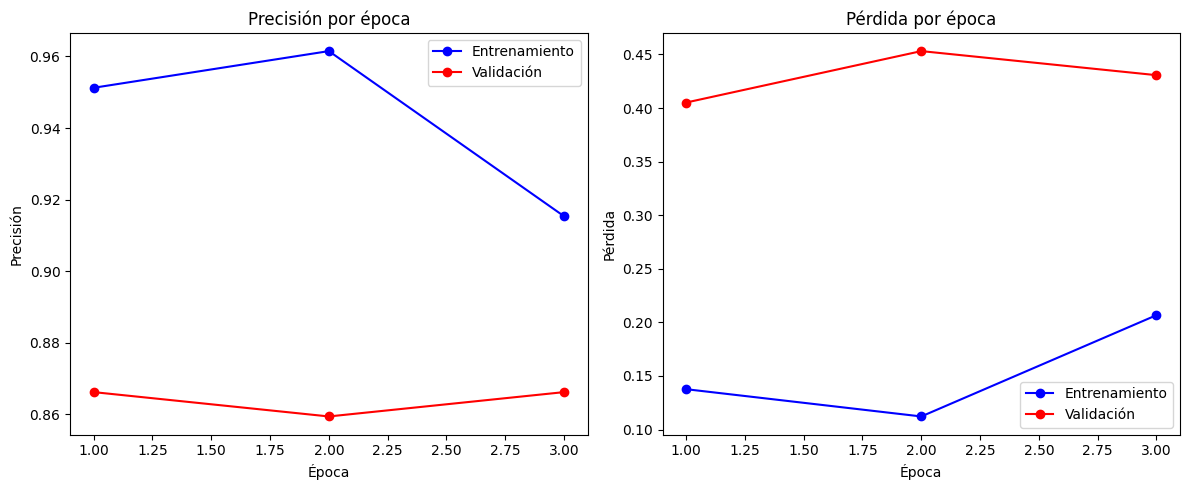

In [17]:
import matplotlib.pyplot as plt

# Extraer métricas del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Precisión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Entrenamiento')
plt.plot(epochs, val_acc, 'ro-', label='Validación')
plt.title('Precisión por época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


 EJERCICIO 4 Predicción del precio de viviendas

    Framework: Keras

    Dataset: fetch_california_housing de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

    Predecir el valor de viviendas en California usando un MLP.

    Implementación: Regresión, MSE, normalización de datos.

In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Cargar datos
data = fetch_california_housing()
X, y = data.data, data.target

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos (muy importante para MLP)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Salida escalar para regresión
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE + MAE
model.summary()


c:\Users\Cristhian Ismael\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
print("Entrenamiento finalizado")


Entrenamiento finalizado


In [21]:
loss, mae = model.evaluate(X_test, y_test)
print(f"MSE: {loss:.4f}")
print(f"MAE: {mae:.4f}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.2767 - mae: 0.3566
MSE: 0.2767
MAE: 0.3566


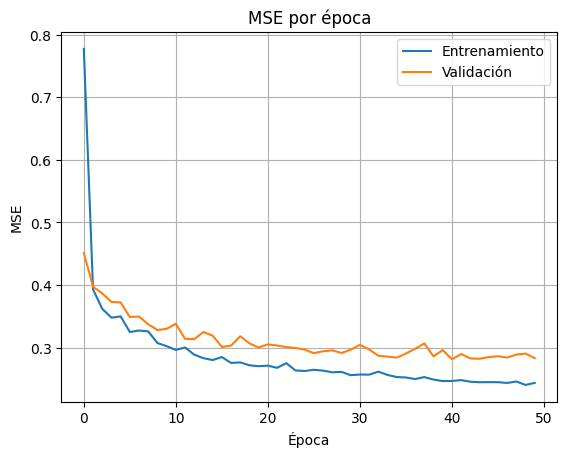

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('MSE por época')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


5. Clasificación de flores por imagen

    Framework: TensorFlow (transfer learning con MobileNet)

    Dataset: Oxford Flowers 102 https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

    Clasificar flores con redes preentrenadas (VGG, ResNet).

    Implementación: Transfer learning, fine-tuning, freezing layers.



preparar el dataset

In [23]:
import tensorflow_datasets as tfds

# Cargar el dataset Oxford Flowers 102
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)


ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Define tamaños
IMG_SIZE = 224
BATCH_SIZE = 32

# Función de preprocesamiento
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    return image, label

# Cargar dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

# Aplicar la función y preparar los datasets
train_ds = ds_train.map(format_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Cargar base preentrenada sin la cabeza final
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze layers

# Construir modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(102, activation='softmax')  # 102 clases de flores
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


In [ ]:
# Descongelar últimas capas del modelo base
base_model.trainable = True

# Entrenar solo las últimas capas
fine_tune_at = 100  # congela hasta esta capa
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # tasa de aprendizaje baja
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fase 2 de entrenamiento
fine_tune_epochs = 5
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=fine_tune_epochs)


In [ ]:
loss, acc = model.evaluate(test_ds)
print(f"Precisión final en test: {acc:.4f}")


In [ ]:
# Obtener nombres de las flores desde la metadata del dataset
class_names = ds_info.features['label'].names


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un lote de imágenes del test set
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)


In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis('off')
    true_label = class_names[labels[i].numpy()]
    predicted_label = class_names[pred_labels[i].numpy()]
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"Pred: {predicted_label}\nReal: {true_label}", color=color)
plt.suptitle("Predicciones del modelo - Oxford Flowers 102", fontsize=16)
plt.tight_layout()
plt.show()
